In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.integrate import ode

<h3>Utils</h3>

In [2]:
def prob(pi,d=None, p=0.5):
    "Simulation of a random integer with law pi_v."
    if type(pi) == str and pi=="poisson":
      d= poisson.rvs(d)
    elif type(pi) == str and pi=="geometric":
      d = np.random.geometric(p)
    else:
      d = np.argmax(pi)
    return d

In [3]:
def vertices(pi,N,C=1,d=None, p=0.5):
   "Return a (N,2) array, each row being of the form [int,0] where int is an integer with law pi"
   
   if type(pi) == str and pi=="poisson":
      x = np.array(poisson.rvs(d, size=N))
   elif type(pi) == str and pi=="geometric":
      x = np.random.geometric(p, size=N)
   else:
      x = np.array([prob(pi) for i in range(N)])
   y = np.ones(N)*C
   z = np.ones(N)*C
   res = np.concatenate((x[:,None],y[:,None],z[:,None]),axis=1)
   res = res.astype(int)
   return res

<h3>Greedy matching</h3>

In [4]:
def greedy_step(x,pi,d=None, p = 0.5):
    "pi : list corresponding to a probability law on the integers"
    
    "x : array of size (len(x),2). The i-th row of x, [int,bool] is interpreted as follows:"
    "vertex number i has remaining degree int and is free if bool=0 and marked if bool=1"
    
    "Return the effect of a step of the greedy matching algorithm,"
    "when a vertex arrives online with degree law pi_u."
    
    deg = prob(pi,d, p=p)
    x_sum = np.sum(x[:,0])
    deg = min(deg,x_sum)
    if deg == 0:
            #print('Every half-edge has already been matched')
        return x
    p = x[:,0] / x_sum
    indices = np.random.choice(np.arange(len(x)),p=p, size=deg)
    for i in indices:
        if x[i,1] > 0:
            x[i,1] -= 1
            break
    x[indices,0] -= 1
    return x 

In [5]:
def multiple_greedy_matching(pi_u,pi_v,N_u,N_v,n_exp=1,C=1,d=None,p=0.5):
    result=[]
    for _ in range(n_exp):
      x = vertices(pi_u,N_u,C,d, p)
      y = x.copy()
      z = x.copy()
      w = x.copy()
      nb_marked_greedy = np.zeros(N_v+1)
      
      for i in range(N_v):
          nb_marked_greedy[i] = np.sum(x[:,2])-np.sum(x[:,1])
          x = greedy_step(x,pi_v,d, p)

      nb_marked_greedy[N_v] = np.sum(x[:,2])- np.sum(x[:,1])
      result.append(nb_marked_greedy)
    
    return result

<h3>Ranking matching</h3>

In [6]:
def ranking_step(x,pi,d=None, p=0.5):
    deg = prob(pi,d, p=p)
    x_sum = np.sum(x[:,0])
    deg = min(deg,x_sum)
    if deg == 0:
            #print('Every half-edge has already been matched')
        return x
    p = x[:,0] / x_sum
    indices = np.random.choice(np.arange(len(x)),p=p, size=deg)
    rankings = x[indices,3]
    indices = indices[np.argsort(rankings)]
    for i in indices:
        if x[i,1] > 0:
            x[i,1] -= 1
            break
    x[indices,0] -= 1
    return x 

<h3>Choose the smallest degree</h3>

In [7]:
def smallest_step(x,pi,d=None, p=0.5):
    
    deg = prob(pi,d, p=p)
    x_sum = np.sum(x[:,0])
    deg = min(deg,x_sum)
    if deg == 0:
            #print('Every half-edge has already been matched')
        return x
    p = x[:,0] / x_sum
    indices = np.random.choice(np.arange(len(x)),p=p, size=deg)

    permutation = np.argsort(x[indices,0])
    indices = indices[permutation]
    
    for idx in indices:
        if x[idx,1] > 0:
            x[idx,1] -= 1
            break
    x[indices,0] -= 1
    
    return x    

<h3>Choose the highest</h3>

In [8]:
def highest_step(x,pi,d=None, p=0.5):
    
    deg = prob(pi,d, p)
    indices= np.zeros(deg)
    
    for i in range(deg):
        if np.sum(x[:,0]) == 0:
            #print('Every half-edge has already been matched')
            return x
        else:
            nb_half_edges = np.sum(x[:,0])
            p = x[:,0] / nb_half_edges
            idx = np.random.choice(np.arange(len(x)),p=p)
            indices[i] = idx
            x[idx,0] -= 1
                    
    indices = np.sort(indices.astype(np.int32))
    
    permutation = np.argsort(x[indices,0])
    indices = np.flip(indices[permutation])
    
    for idx in indices:
        if x[idx,1] > 0:
            x[idx,1] -= 1
            break
    
    return x  

In [9]:
def highest_step(x,pi,d=None, p=0.5):

    deg = prob(pi,d, p=p)
    x_sum = np.sum(x[:,0])
    deg = min(deg,x_sum)
    if deg == 0:
            #print('Every half-edge has already been matched')
        return x
    p = x[:,0] / x_sum
    indices = np.random.choice(np.arange(len(x)),p=p, size=deg)

    permutation = np.argsort(x[indices,0])[::-1]
    indices = indices[permutation]
    
    for idx in indices:
        if x[idx,1] > 0:
            x[idx,1] -= 1
            break
    x[indices,0] -= 1
    return x  

<h3>Compare the four</h3>

In [10]:
def four_matchings(pi_u,pi_v,N_u,N_v,C=1,d=None, p=0.5):
    
    x = vertices(pi_u,N_u,C,d, p)
    # ranking
    y = np.concatenate((x.copy(),np.random.permutation(np.arange(N_u))[:,None]),axis=1) 

    z = x.copy()
    w = x.copy()
    nb_marked_greedy = np.zeros(N_v+1)
    nb_marked_ranking = np.zeros(N_v+1)
    nb_marked_smallest = np.zeros(N_v+1)
    nb_marked_highest = np.zeros(N_v+1)
    deg = int(np.max(x[:,0]))
    #print(deg)
    nb_deg_greedy = np.zeros((deg,N_v+1))
    nb_deg_ranking = np.zeros((deg,N_v+1))
    
    for i in range(N_v):
        nb_marked_greedy[i] = np.sum(x[:,2])-np.sum(x[:,1])
        nb_marked_ranking[i] = np.sum(y[:,2])-np.sum(y[:,1])
        current_greedy =  x[np.where(x[:,1] == 1)]
        current_ranking =  y[np.where(y[:,1] == 1)]
        # if i%1000==0:
        #   #print(i)
        for l in range(deg):
          nb_deg_greedy[l,i] = np.count_nonzero(current_greedy[:,0] == l+1)
          nb_deg_ranking[l,i] = np.count_nonzero(current_ranking[:,0] == l+1)
          nb_marked_smallest[i] = np.sum(z[:,2])-np.sum(z[:,1])
          nb_marked_highest[i] = np.sum(w[:,2])-np.sum(w[:,1])
        x = greedy_step(x,pi_v,d, p)
        y = ranking_step(y,pi_v,d, p)
        z = smallest_step(z,pi_v,d, p)
        w = highest_step(w,pi_v,d, p)
      
    nb_marked_greedy[N_v] = np.sum(x[:,2])- np.sum(x[:,1])
    nb_marked_ranking[N_v] = np.sum(y[:,2])-np.sum(y[:,1])
    nb_marked_smallest[N_v] = np.sum(z[:,2])- np.sum(z[:,1])
    nb_marked_highest[N_v] = np.sum(w[:,2])-np.sum(w[:,1])
    
    return nb_marked_greedy, nb_marked_ranking,nb_marked_smallest, nb_marked_highest

<h3>The d-regular case</h3>

In [162]:
d = 20

pi = np.zeros(d+1)
pi[d] = 1

pi_u = pi
pi_v = pi

N_u = 1000
N_v = 1000

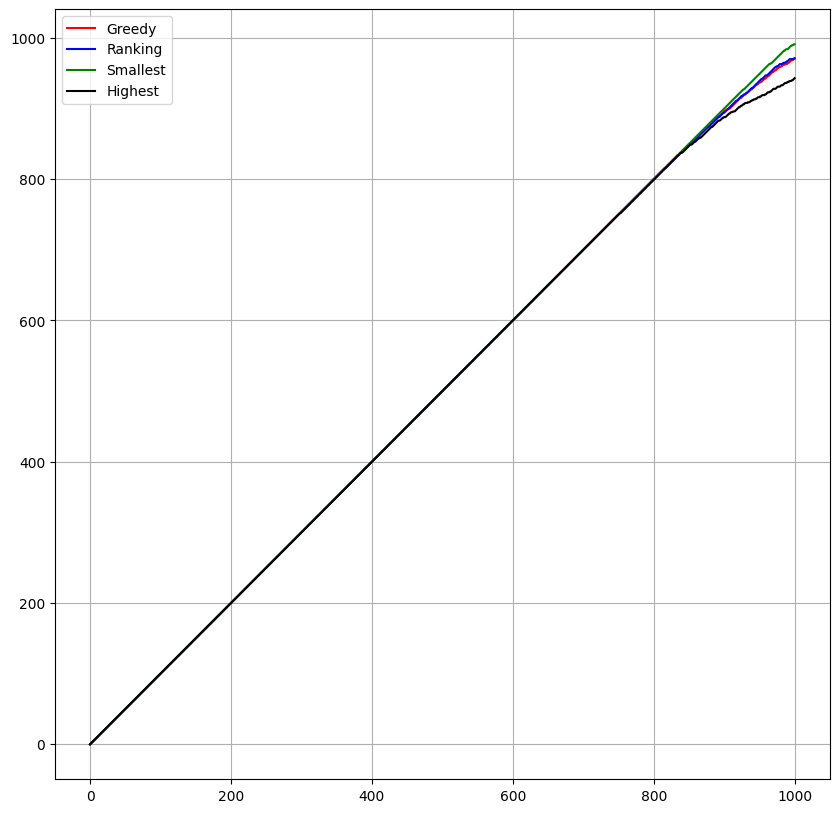

In [163]:
nb_marked_greedy, nb_marked_ranking, nb_marked_smallest, nb_marked_highest = four_matchings(pi_u,pi_v,N_u,N_v)

plt.figure(1,figsize=(10,10))
plt.grid()
plt.plot(np.arange(len(nb_marked_greedy)), nb_marked_greedy, color='red', label='Greedy')
plt.plot(np.arange(len(nb_marked_greedy)), nb_marked_ranking, color='blue', label='Ranking')
plt.plot(np.arange(len(nb_marked_greedy)), nb_marked_smallest, color='green', label='Smallest')
plt.plot(np.arange(len(nb_marked_greedy)), nb_marked_highest, color='black', label='Highest')
plt.legend(loc='best')
plt.savefig(f'Compare_(d={d},N={N_v})')
plt.show()
plt.close(1)

In [164]:
print(nb_marked_highest[N_v])
print(nb_marked_smallest[N_v])

943.0
991.0


In [141]:
print(nb_marked_highest[N_v])
print(nb_marked_smallest[N_v])

973.0
971.0


# ODE d-regular

In [165]:
d = 4

#law of degrees
pi = np.zeros(d+1)
pi[d] = 1

pi_u = pi
pi_v = pi

In [166]:
def regular_ode(t,g,d):
  n= 1-(1-(1-g)**(d-1))**d
  r= d*(1-g)**(d-1)
  return n/r

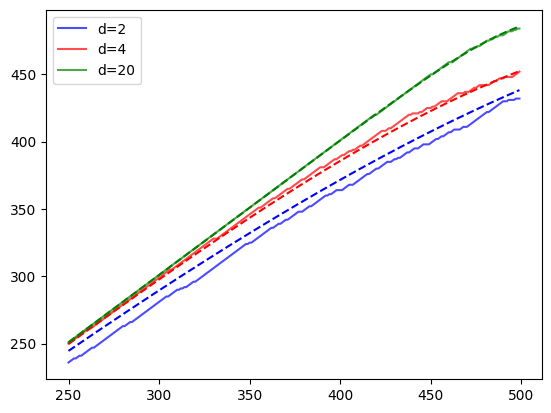

In [167]:
g0, t0 = [0], 0
colors =['r','g','b']
a=-1
for d in [2,4,20]:
  a+=1
  N_u = 500
  N_v = 500

  #law of degrees
  pi = np.zeros(d+1)
  pi[d] = 1

  pi_u = pi
  pi_v = pi
  start=int(N_v/2)
  end=N_v
  r = ode(regular_ode).set_integrator('lsoda', method='bdf')
  r.set_initial_value(g0, t0).set_f_params(d)
  t1 = 1
  dt = 1/N_v
  result =[]
  t=[]
  while r.successful() and r.t <= t1:
      t.append((r.t+dt))
      result.append(N_v*(1-(1-r.integrate(r.t+dt))**d)[0])
  #Number of vertices
  result_simu= multiple_greedy_matching(pi_u,pi_v,N_u,N_v,n_exp=1)
  for nb_marked_greedy in result_simu:
    plt.plot(np.arange(N_v)[start:end], result[start:end],'--',c=colors[a-1])
    plt.plot(np.arange(N_v)[start:end],nb_marked_greedy[start+1:end+1],c=colors[a-1], label="d="+str(d), alpha=0.7)

plt.legend(loc='best')

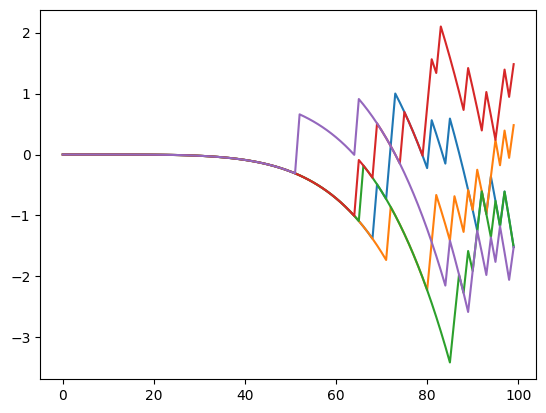

In [169]:
g0, t0 = [0], 0
d=4
#law of degrees
pi = np.zeros(d+1)
pi[d] = 1

pi_u = pi
pi_v = pi

N_u = 100
N_v = 100
r = ode(regular_ode).set_integrator('lsoda', method='bdf')
r.set_initial_value(g0, t0).set_f_params(d)
t1 = 1
dt = 1/N_v
result =[]
t=[]
while r.successful() and r.t <= t1:
    t.append((r.t+dt))
    result.append(N_v*(1-(1-r.integrate(r.t+dt))**d)[0])
#Number of vertices
result_simu= multiple_greedy_matching(pi_u,pi_v,N_u,N_v,n_exp=5)
for nb_marked_greedy in result_simu:
  plt.plot(np.arange(N_v), result-nb_marked_greedy[1:])

# Erdos Renyi graph

In [25]:
def erdos_ode(t,g,d):
  n =1-np.exp(-d*np.exp(-d*g))
  r = d*np.exp(-d*g)
  return n/r

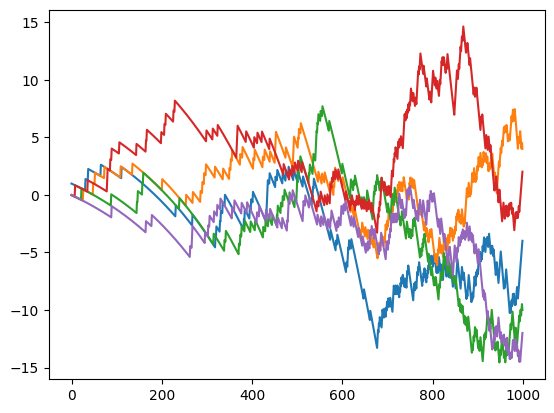

In [26]:
d = 4

pi_u = "poisson"
pi_v = "poisson"
N_u = 1000
N_v = 1000
r = ode(erdos_ode).set_integrator('lsoda', method='bdf')
r.set_initial_value(g0, t0).set_f_params(d)
t1 = 1
dt = 1/N_v
result =[]
t=[]
while r.successful() and r.t <= t1:
    t.append((r.t+dt))
    result.append(N_v*(1-np.exp(-d*(r.integrate(r.t+dt))) )[0])
#Number of vertices
result_simu= multiple_greedy_matching(pi_u,pi_v,N_u,N_v,n_exp=5,d=4)
for nb_marked_greedy in result_simu:
    plt.plot(np.arange(N_v), result-nb_marked_greedy[1:])

done integrating 100
done simulating 100
done integrating 1000
done simulating 1000
done integrating 10000
done simulating 10000


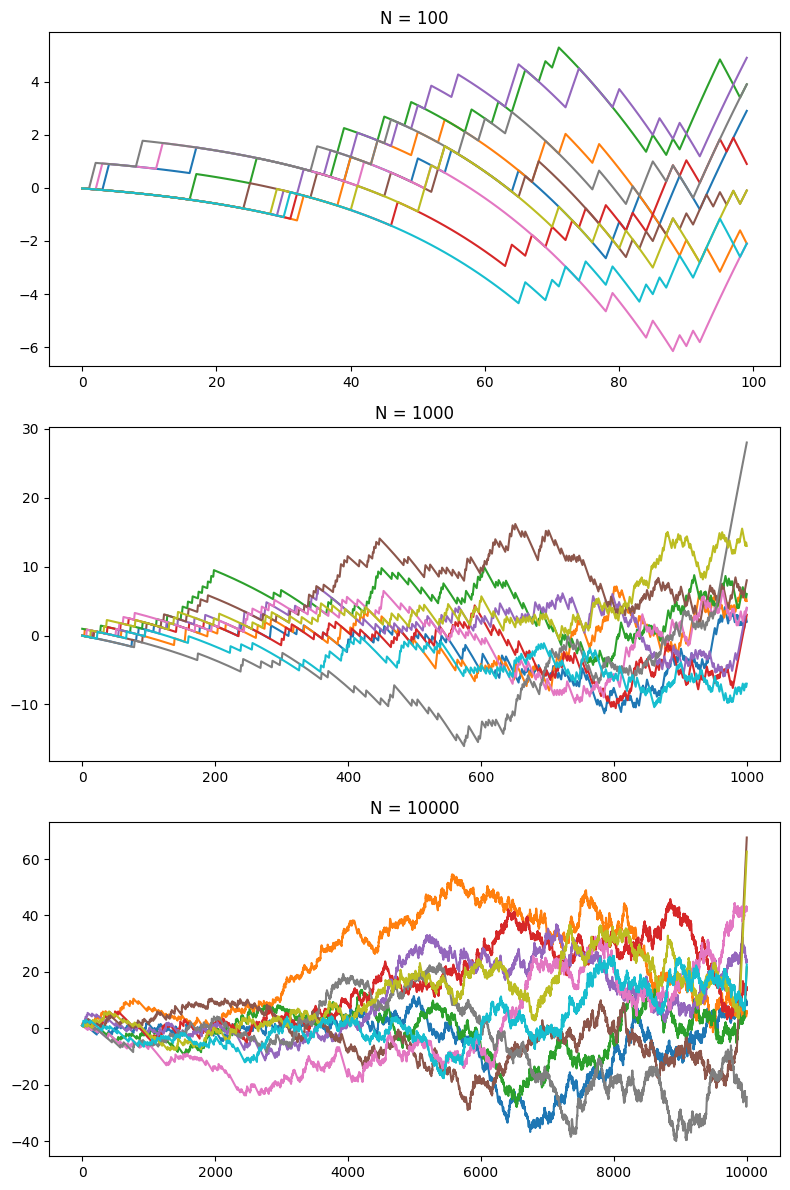

In [172]:
from scipy.integrate import ode
import matplotlib.pyplot as plt
# solve for ode_geometric_law
pi_u = "poisson"
pi_v = "poisson"
g0,t0 = 0,0

fig, axs = plt.subplots(3, 1, figsize=(8, 12))
i = 0
d = 4
for N_u in [100, 1000, 10000]:
    N_v = N_u
    r = ode(erdos_ode).set_integrator('lsoda', method='bdf')
    r.set_initial_value(g0, t0, ).set_f_params(d)
    t1 = 1
    dt = 1/N_v
    result =[]
    t=[]
    r_values = []
    while r.successful() and r.t <= t1:
        t.append((r.t+dt))
        temp = r.integrate(r.t+dt)
        result.append(N_v*(1-np.exp(-d*temp[0])))
        r_values.append(temp[0])
    print(f"done integrating {N_u}")
    result_simu= multiple_greedy_matching(pi_u,pi_v,N_u,N_v,n_exp=10,d=d)
    print(f"done simulating {N_u}")
    for nb_marked_greedy in result_simu:

        if N_u == 100:
            axs[i].plot(np.arange(N_v), np.array(result)-nb_marked_greedy[1:])
        elif N_u == 1000:
            axs[i].plot(np.arange(N_v), np.array(result)-nb_marked_greedy[1:])
        else:
            axs[i].plot(np.arange(N_v), np.array(result[1:])-nb_marked_greedy[1:])
    
    axs[i].set_title(f'N = {N_u}')
    i += 1

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [12]:
N_u = 100
N_v = 100

pi_u ="poisson"
pi_v = "poisson"

for d in np.arange(1,7,1):
    result = np.zeros((1000,2))
    for i in range(1000):
        nb_marked_greedy, nb_marked_ranking, nb_marked_smallest, nb_marked_highest = four_matchings(pi_u, pi_v, N_u, N_v, d=d)
        result[i,0] = nb_marked_greedy[-1]
        result[i,1] = nb_marked_ranking[-1]
    greedy_perf = np.mean(result[:,0])
    ranking_perf = np.mean(result[:,1])
    print(f'- d = {d}, greedy_perf = {greedy_perf}, ranking_perf = {ranking_perf}')

- d = 1, greedy_perf = 49.072, ranking_perf = 49.188
- d = 2, greedy_perf = 67.372, ranking_perf = 67.244
- d = 3, greedy_perf = 76.523, ranking_perf = 76.482
- d = 4, greedy_perf = 82.004, ranking_perf = 81.971
- d = 5, greedy_perf = 85.414, ranking_perf = 85.338
- d = 6, greedy_perf = 87.789, ranking_perf = 87.752


# ODE geometric graph

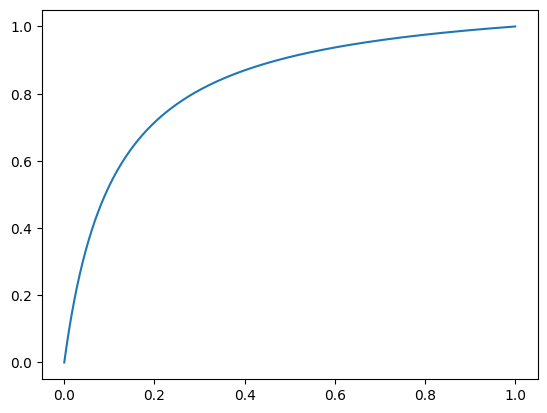

In [ ]:
def phi_u(x, p):
    return p * x / (1-(1-p)*x)

x = np.linspace(0, 1, 1000)
plt.plot(x, 1 - phi_u(1- x, 0.1))

def phi_prime_u(x, p):
    return p/(1-(1-p)*x)**2

def ode_geometric_law(t, g, p):
    numer = 1 - phi_u(1- phi_prime_u(1-g, p) * p  , p)
    denom = phi_prime_u(1 - g, p)
    return numer/denom

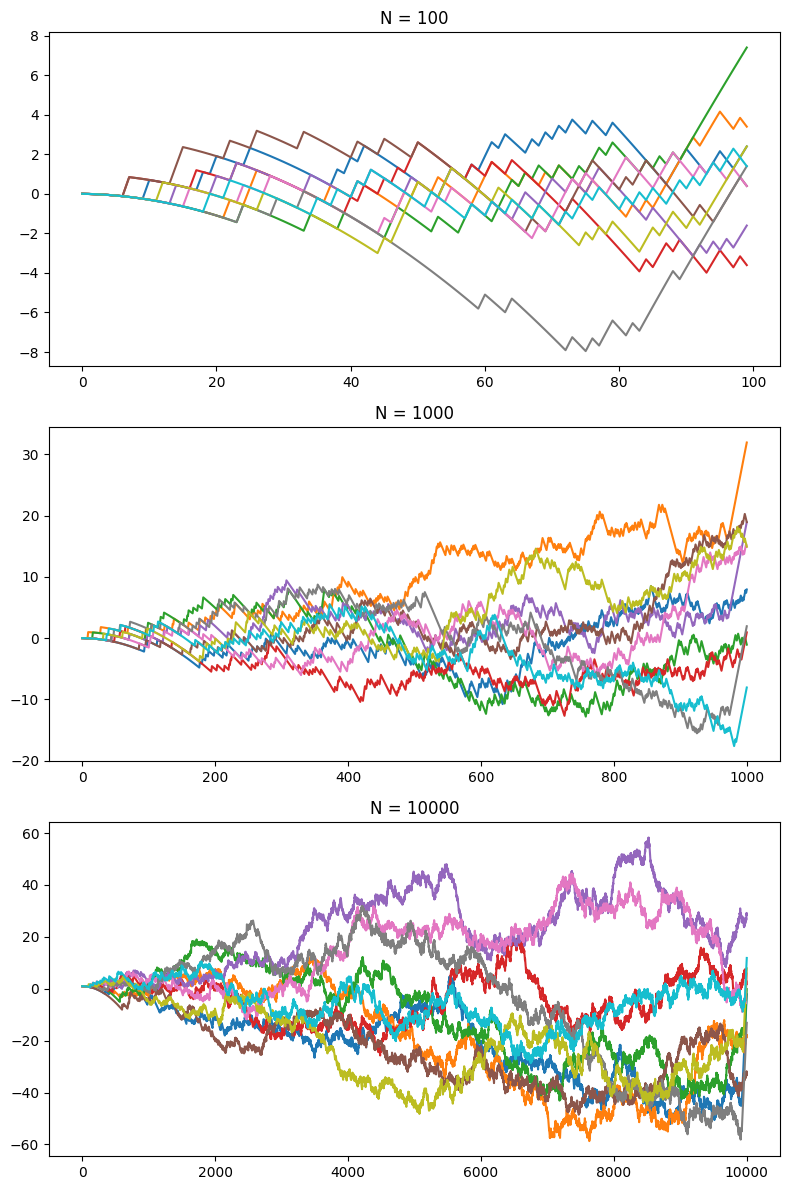

In [ ]:
from scipy.integrate import ode
import matplotlib.pyplot as plt
# solve for ode_geometric_law
pi_u = "geometric"
pi_v = "geometric"
g0,t0 = 0,0

fig, axs = plt.subplots(3, 1, figsize=(8, 12))
i = 0
p = 0.5
for N_u in [100, 1000, 10000]:
    N_v = N_u
    r = ode(ode_geometric_law).set_integrator('lsoda', method='bdf')
    r.set_initial_value(g0, t0, ).set_f_params(p)
    t1 = 1
    dt = 1/N_v
    result =[]
    t=[]
    r_values = []
    while r.successful() and r.t <= t1:
        t.append((r.t+dt))
        temp = r.integrate(r.t+dt)
        result.append(N_v*(1-phi_u(1-temp[0], p)))
        r_values.append(temp[0])

    result_simu= multiple_greedy_matching(pi_u,pi_v,N_u,N_v,n_exp=10,d=4,p=p)

    for nb_marked_greedy in result_simu:

        if N_u == 100:
            axs[i].plot(np.arange(N_v), np.array(result)-nb_marked_greedy[1:])
        elif N_u == 1000:
            axs[i].plot(np.arange(N_v), np.array(result)-nb_marked_greedy[1:])
        else:
            axs[i].plot(np.arange(N_v), np.array(result[1:])-nb_marked_greedy[1:])
    
    axs[i].set_title(f'N = {N_u}')
    i += 1

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
print(np.array(result_simu).shape)
np.array(result).shape

(10, 10001)


(10001,)

In [ ]:
mean = np.mean(np.array(result)[..., None] - nb_marked_greedy)


In [ ]:
import plotly.graph_objs as go

N_u = 100
N_v = 100
nb_marked_greedy, nb_marked_ranking, nb_marked_smallest, nb_marked_highest = four_matchings(pi_u, pi_v, N_u, N_v, p=0.9)

# Create traces
trace1 = go.Scatter(x=np.arange(len(nb_marked_greedy)), y=nb_marked_greedy/N_v, mode='lines', name='Greedy', line=dict(color='red'))
trace2 = go.Scatter(x=np.arange(len(nb_marked_greedy)), y=nb_marked_ranking/N_v, mode='lines', name='Ranking', line=dict(color='blue'))
trace3 = go.Scatter(x=np.arange(len(nb_marked_greedy)), y=nb_marked_smallest/N_v, mode='lines', name='Smallest', line=dict(color='green'))
trace4 = go.Scatter(x=np.arange(len(nb_marked_greedy)), y=nb_marked_highest/N_v, mode='lines', name='Highest', line=dict(color='black'))

data = [trace1, trace2, trace3, trace4]

layout = go.Layout(title='Four Matchings', xaxis=dict(title='Index'), yaxis=dict(title='Ratio'), legend=dict(x=0, y=1))

fig = go.Figure(data=data, layout=layout)
fig.show()


In [ ]:
N_u = 100
N_v = 100

for p in np.arange(0.1,1,0.1):
    result = np.zeros((100,2))
    for i in range(100):
        nb_marked_greedy, nb_marked_ranking, nb_marked_smallest, nb_marked_highest = four_matchings(pi_u, pi_v, N_u, N_v, p=p)
        result[i,0] = nb_marked_greedy[-1]
        result[i,1] = nb_marked_ranking[-1]
    greedy_perf = np.mean(result[:,0])
    ranking_perf = np.mean(result[:,1])
    print(f'- p = {p}, greedy_perf = {greedy_perf}, ranking_perf = {ranking_perf}')


- p = 0.1, greedy_perf = 76.93, ranking_perf = 79.39
- p = 0.2, greedy_perf = 74.4, ranking_perf = 74.56
- p = 0.30000000000000004, greedy_perf = 72.36, ranking_perf = 72.89
- p = 0.4, greedy_perf = 73.23, ranking_perf = 72.26
- p = 0.5, greedy_perf = 74.64, ranking_perf = 74.55
- p = 0.6, greedy_perf = 76.74, ranking_perf = 76.65
- p = 0.7000000000000001, greedy_perf = 79.66, ranking_perf = 79.54
- p = 0.8, greedy_perf = 83.97, ranking_perf = 84.24
- p = 0.9, greedy_perf = 90.89, ranking_perf = 89.89


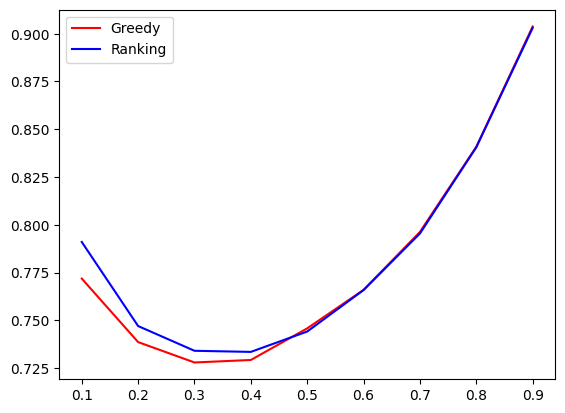

In [ ]:
greedy_perf = [ 77.186,73.862,72.796,72.927,74.581,76.597,79.629,84.086,90.379 ]
ranking_perf = [  79.102,74.702,73.408,73.350,74.416,76.586,79.546,84.058,90.306 ]
p = np.arange(0.1,1,0.1)
plt.plot(p, np.array(greedy_perf)/100, color='red', label='Greedy')
plt.plot(p, np.array(ranking_perf)/100, color='blue', label='Ranking')
plt.legend(loc='best')
plt.savefig(f'Compare_(d={d},N={N_v})')
plt.show()
plt.close(1)

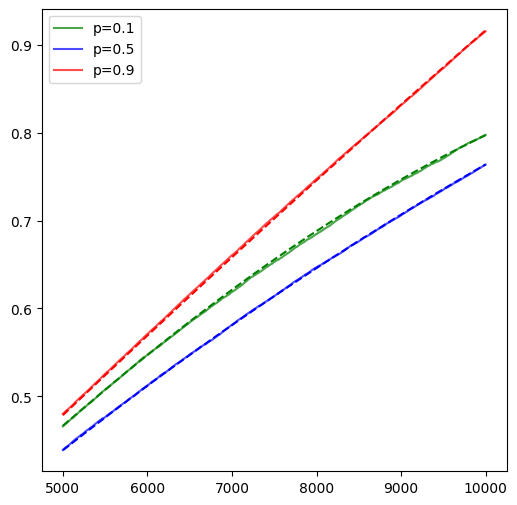

In [ ]:
from scipy.integrate import ode
import matplotlib.pyplot as plt
# solve for ode_geometric_law
pi_u = "geometric"
pi_v = "geometric"
g0,t0 = 0,0

plt.figure(figsize=(6,6))
i = 0
p = 0.5
N_u, N_v = 10000, 10000
colors =['r','g','b']
a=-1
for p in [0.1, 0.5, 0.9]:
    r = ode(ode_geometric_law).set_integrator('lsoda', method='bdf')
    r.set_initial_value(g0, t0, ).set_f_params(p)
    t1 = 1
    dt = 1/N_v
    result =[]
    t=[]
    start=int(N_v/2)
    end=N_v
    r_values = []
    while r.successful() and r.t <= t1:
        t.append((r.t+dt))
        temp = r.integrate(r.t+dt)
        result.append(N_v*(1-phi_u(1-temp[0], p)))
        r_values.append(temp[0])

    result_simu= multiple_greedy_matching(pi_u,pi_v,N_u,N_v,n_exp=1,d=4,p=p)
    
    for nb_marked_greedy in result_simu:
        plt.plot(np.arange(N_v)[start:end], np.array(result[start:end]) / N_v,'--',c=colors[a-1])
        plt.plot(np.arange(N_v)[start:end],np.array(nb_marked_greedy[start+1:end+1]) / N_v,c=colors[a-1], label="p="+str(p), alpha=0.7) #nb_marked_greedy[start+1:end+1],c=colors[a-1], label="p="+str(p), alpha=0.7)

    a+=1
    

# Show plot
plt.legend(loc='best')
plt.show()
